<a href="https://colab.research.google.com/github/Ili02/CARe_Python_Class_2023/blob/master/projet_ia_cnn_ilias_simon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About

After completion of this tutorial, you should be able to import data, transform it, and efficiently feed the data in batches to a convolution neural network (CNN) model for image classification.


**Author:** Mohit VAISHNAV

In [ ]:
## import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
print(torch.__version__)

2.2.1+cu121


## Import The Data
The first step before training the model is to import the data. We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) which is like the Hello World dataset of machine learning.

Besides importing the data, we will also do a few more things:
- We will tranform the data into tensors using the `transforms` module
- We will use `DataLoader` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models.
- As hinted above, we will also create batches of the data by setting the `batch` parameter inside the data loader. Notice we use batches of `32` in this tutorial but you can change it to `64` if you like. I encourage you to experiment with different batches.

In [ ]:
%%capture
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST

trainset = MNIST(root = './', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = MNIST(root = './', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

## Exploring the Data
As a practioner and researcher, I am always spending a bit of time and effort exploring and understanding the dataset. It's fun and this is a good practise to ensure that everything is in order.

Let's check what the train and test dataset contains. I will use `matplotlib` to print out some of the images from our dataset.

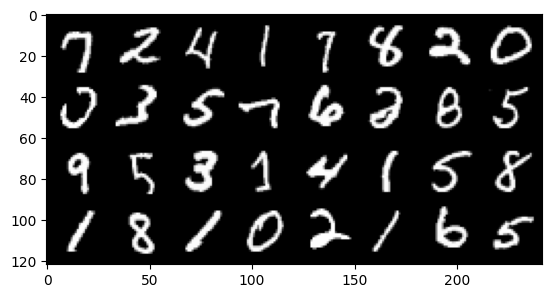

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images))

**EXERCISE:** Try to understand what the code above is doing. This will help you to better understand your dataset before moving forward.
*give an explanation!!*

Let's check the dimensions of a batch.

In [ ]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    print(labels)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([4, 5, 3, 8, 6, 5, 5, 2, 6, 0, 0, 7, 7, 6, 6, 1, 6, 1, 3, 8, 5, 5, 4, 2,
        9, 7, 1, 1, 6, 6, 4, 3])


In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32 images x1 gray scale x28x28 size => 32 images x32 out_channel x26x26 size reduced after
        #conv (filter size 3)
        x = self.conv1(x)
        x = F.relu(x) #relu f() linear function above f(x<0)=0/ f(x>0)=x

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1) #for prob
        return out

I always encourage to test the model with 1 batch to ensure that the output dimensions are what we expect.

In [ ]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    print(out[0])
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])
tensor([0.1045, 0.1055, 0.0925, 0.0984, 0.0992, 0.1050, 0.0947, 0.1048, 0.0910,
        0.1044], grad_fn=<SelectBackward0>)


The model isn't trained yet, therefor it should be random probabilities ~1/10 dimensions (32*10 after .d2)

## Training the Model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model.

In [ ]:
learning_rate = 0.001
num_epochs = 1
#epochs = nb of time the dataset is read

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss() #assess corect = highest score wrong = lowest
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #weight update (Adam=one of the way)

In [ ]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.argmax(logit, 1) == target).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

Now it's time for training.

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)

    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 1.6224 | Train Accuracy: 84.21


We can also compute accuracy on the testing dataset to see how well the model performs on the image classificaiton task. As you can see below, our basic CNN model is performing very well on the MNIST classification task.

In [ ]:
test_acc = 0.0
model = model.eval()
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 96.73


**EXERCISE:** As a way to practise, try to include the testing part inside the code where I was outputing the training accuracy, so that you can also keep testing the model on the testing data as you proceed with the training steps. This is useful as sometimes you don't want to wait until your model has completed training to actually test the model with the testing data.

**GOING FURTHER:**
Try changing the architecture of the model and the hyperparameters.
How does the accuracy evolves with your changes?

## Final Words
That's it for this tutorial! Congratulations! You are now able to implement a basic CNN model in PyTorch for image classification. If you would like, you can further extend the CNN model by adding more convolution layers and max pooling, but as you saw, you don't really need it here as results look good. If you are interested in implementing a similar image classification model using RNNs see the references below.

## References
- [Building RNNs is Fun with PyTorch and Google Colab](https://colab.research.google.com/drive/1NVuWLZ0cuXPAtwV4Fs2KZ2MNla0dBUas)
- [CNN Basics with PyTorch by Sebastian Raschka](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-basic.ipynb)
- [Tensorflow 2.0 Quickstart for experts](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb#scrollTo=DUNzJc4jTj6G)

- [Elvis Saravia](https://colab.research.google.com/github/dair-ai/notebooks/blob/master/_notebooks/2020-03-18-pytorch_quick_start.ipynb#scrollTo=tmaCTw5tXowR)

# MY PERSONAL ADDITION IN THE CELLS BELOW




# **What i did to ameliorate the CNN:**

This model starts with an input layer that indicates the input format of the images into the model, which is 28 pixels by 28 , in one dimension.

I divided the model in 3 blocks. Each block is composed of convolution-normalization-maxpool.

For the first block:
**Convolution**
The 28x28x1 image is processed through a first convolution layer, which apply a kernel of size 3*3, with 32 neurons.
Here, according to the formula:

n out= (n in + 2x padding - kernel)/stride +1

n out = (28+2*1-3)/1 +1 =28

n out= n in

**Normalization**
The data then passes to a  BatchNormalization. Batch Norm is commonly used in CNN to improve the learning speed of Neural Networks and provides regularization, avoiding overfitting.

**MaxPooling**
Normalized data passes through a MaxPooling. MaxPooling (2,2) reduces the size of the data as it keeps only the highest value of 4. This extracts the most important features reducing the computational load and controlling overfitting.

The data passess through 4 successives blocks, with for each block an increased number of features (neurons).

Finally two fully connected layers (fc1, fc2) are defined for classification.

The first fully connected layer (fc1) takes the flattened output from the convolutional layers and produces a feature vector with 500 dimensions. The second fully connected layer (fc2) further reduces the features to 10, corresponding to the 10 classes.

**Dropout**
The fc1 layer undergoes a dropout, meaning that a random part of the neurons are turned off. Dropout layers randomly set a fraction of input units to zero during training, which helps prevent o![improved_CNN_2.png](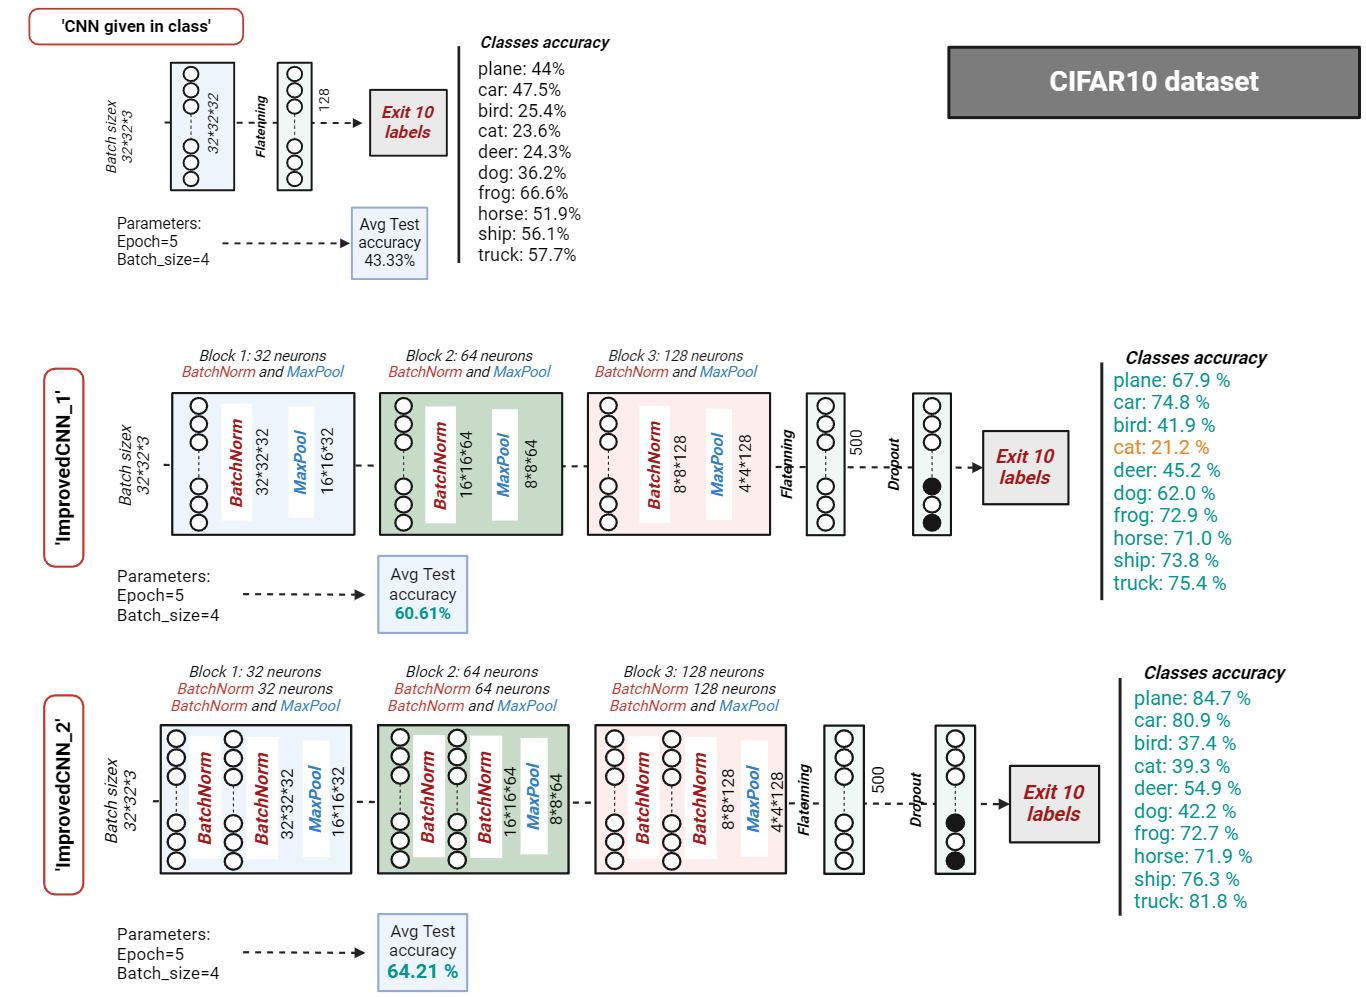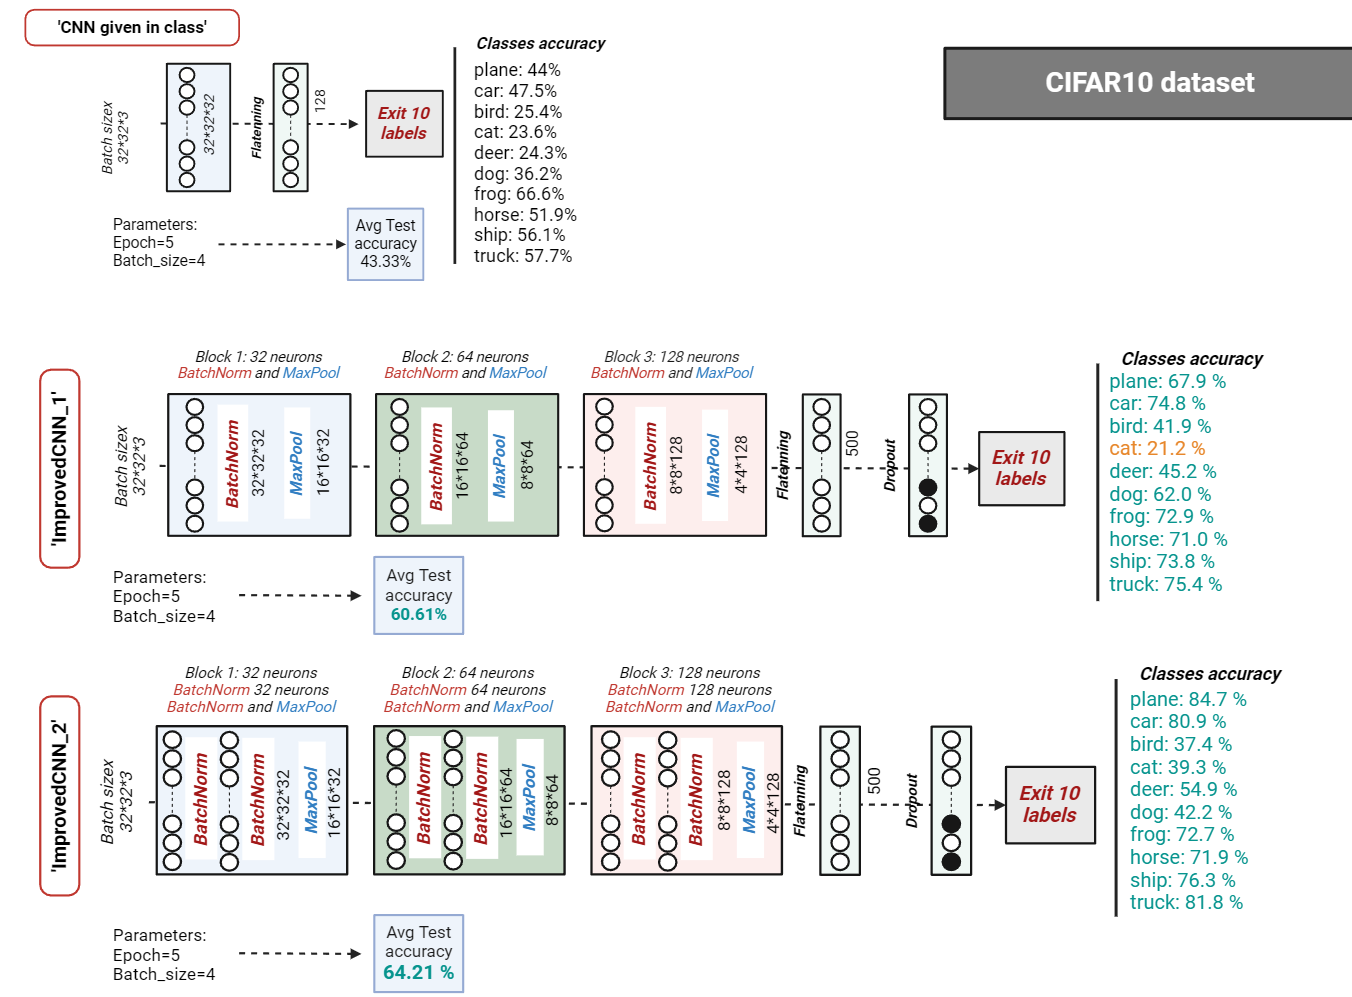)verfitting by providing a form of regularization.


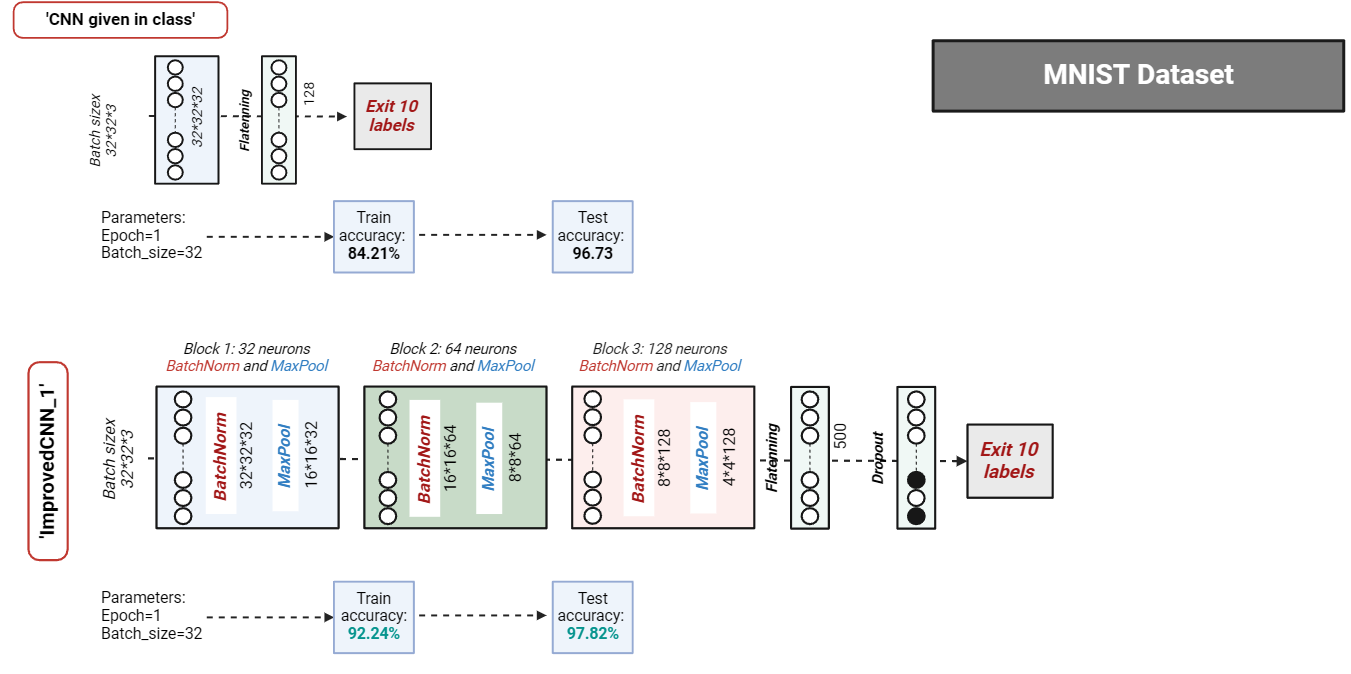

Only small progress was made with the additions, so i decided to test on other dataset, more complex to see if the new CNN was performing better.



--2024-04-29 15:28:59--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2024-04-29 15:29:00--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [      <=>           ]  33.20M  6.66MB/s    in 5.8s    

2024-04-29 15:29:06 (5.68 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([6, 1, 6, 5, 2, 7, 2, 4, 9, 1, 2, 9, 9, 2, 6, 2, 3, 5, 1, 0, 7, 7, 8, 7,
        2, 9, 1, 2, 3, 1, 8, 7])


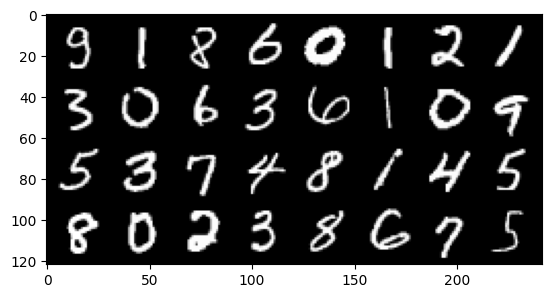

In [ ]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

#number of images that will be used for training
BATCH_SIZE = 32

## transformations to pytorch tensors
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz
from torchvision.datasets import MNIST
trainset = MNIST(root = './', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
## download and load testing dataset
testset = MNIST(root = './', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

## functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
## get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    print(labels)
    break
dataiter2 = iter(trainloader)
images, labels = next(dataiter2)
imshow(torchvision.utils.make_grid(images))

Epoch: 0 | Loss: 1.5417 | Train Accuracy: 92.24
Test Accuracy: 97.82
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])


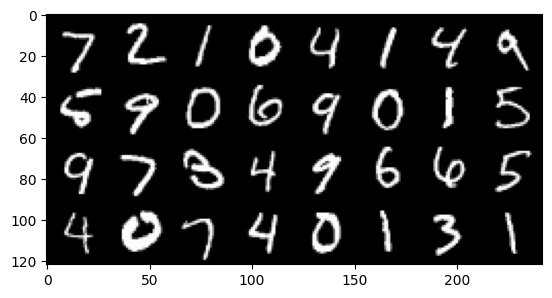

In [ ]:
###CNN improved_1:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN_1(nn.Module):
    def __init__(self):
        super(ImprovedCNN_1, self).__init__()

        # Convolutional layers
        #28*28*1 => 28*28*32 size is kept: n out= (n in+2padding+kernel)/stride
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Batch normalization layers
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 500)
        self.fc2 = nn.Linear(500, 10)

        # Dropout layers
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.batch_norm1(self.conv1(x)))
        #print(x.shape) #torch.Size([16, 32, 28, 28])
        x = self.pool(x)
        #print(x.shape) #torch.Size([16, 32, 14, 14])
        x = F.relu(self.batch_norm2(self.conv2(x)))
        #print(x.shape) #torch.Size([16, 64, 14, 14])
        x = self.pool(x)
        #print(x.shape) #torch.Size([16, 64, 7, 7])
        x = F.relu(self.batch_norm3(self.conv3(x)))
        #print(x.shape) #torch.Size([16, 128, 7, 7])
        x = self.pool(x)
        #print(x.shape) #torch.Size([16, 128, 3, 3])

        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.dropout(self.fc1(x)))
        x = (self.fc2(x))

        return F.softmax(x, dim=1)

#training initialisation
learning_rate = 0.001
num_epochs = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ImprovedCNN_1()
model = model.to(device)
criterion = nn.CrossEntropyLoss() #assess corect = highest score / wrong = lowest
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #weight update (Adam=one of the way)

#compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.argmax(logit, 1) == target).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

#Training
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0
    model = model.train()

    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)

    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

#TEST!
test_acc = 0.0
model = model.eval()
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Test Accuracy: %.2f'%( test_acc/i))

#print test image and respective values attribuated by the CNN
dataiter2 = iter(testloader)
images, labels = next(dataiter2)
imshow(torchvision.utils.make_grid(images))
for images, labels in testloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    print(labels)
    break


# ***Classification test on another dataset:***

I used the CIFAR10 dataset, composed of images of 32x32x3 (RGB). The images represents 10 different classes, dog, cat, plane, bird, deer, frog, horse, car, ship and truck.
For the loading and test, i took the code from:

https://github.com/patrickloeber/pytorchTutorial/blob/69637721ed9fa2ccf81a1093a928a52bbb591439/14_cnn.py#L26

In the first place, i tested the model used in class; which achieved a score of approximately 43% classification accuracy.

Then, i tested the 'improvedCNN_1' model that i have made previously on this dataset. It reaches a classification accuracy of 60.61%% with the same parameters. The model was better to classify more complex datasets.

To improve it, i added after each BatchNorm a new convolution layer with the same number of feature than the previous one. The idea is to work/learn on the features before a second layer of Batch_Normalization. The following scheme represents the 'improvedCNN_2' architecture that i found out was working the best, with an average accuracy of 64.21%.

The accuracy score could still be improved by increasing the epoch , but for technical reasons (lack of gpu access) i didn't tried.




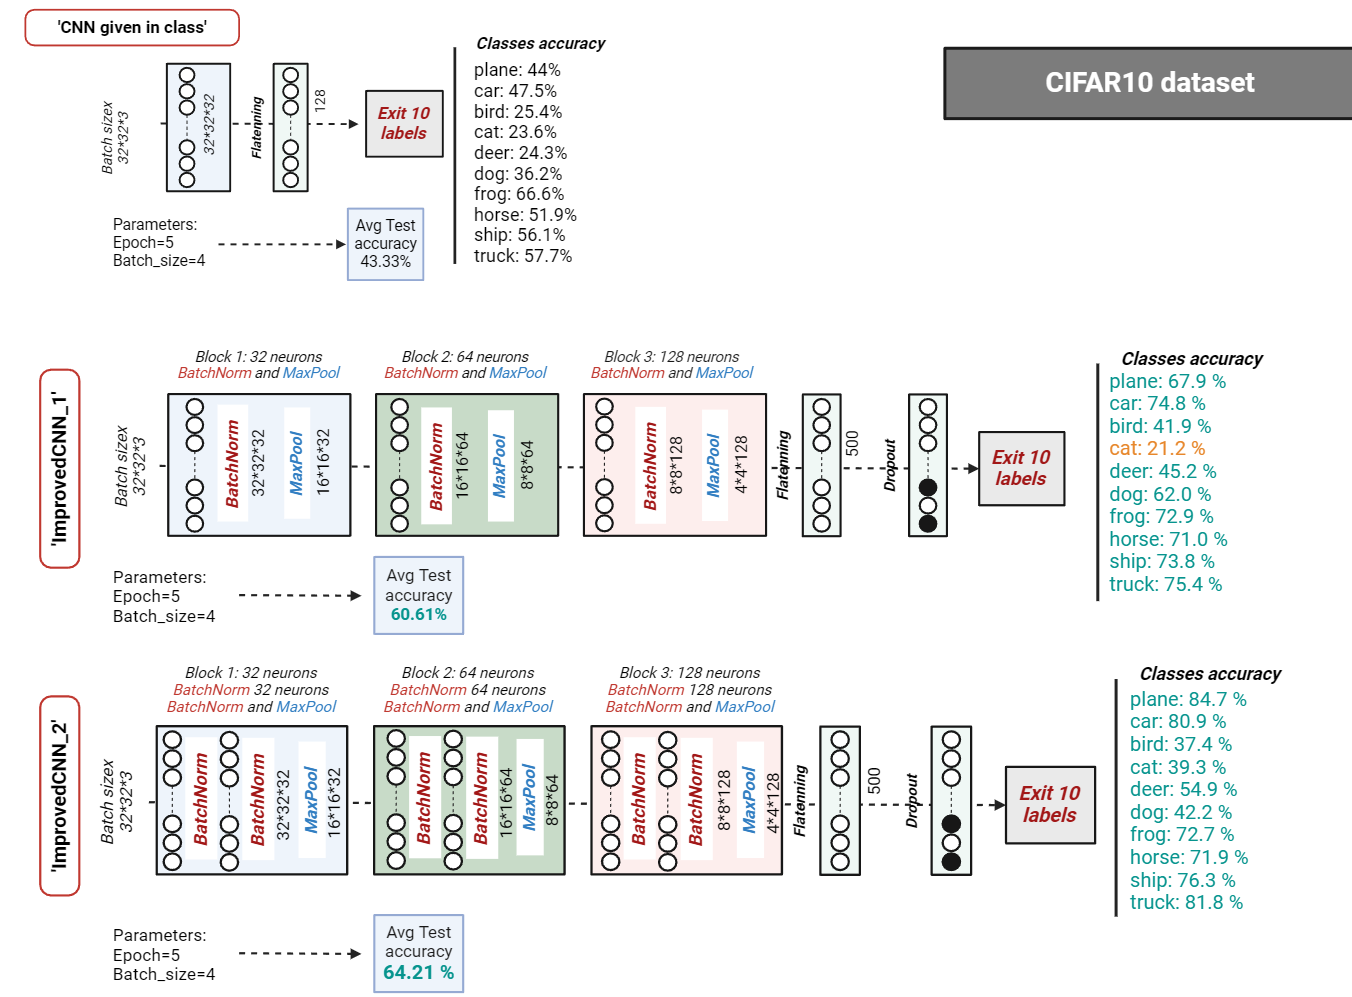

100%|██████████| 170498071/170498071 [00:12<00:00, 13164580.15it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


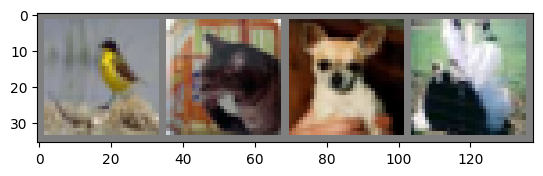

Epoch [1/5], Step [2000/12500], Loss: 2.2500
Epoch [1/5], Step [4000/12500], Loss: 2.2861
Epoch [1/5], Step [6000/12500], Loss: 2.2019
Epoch [1/5], Step [8000/12500], Loss: 2.3399
Epoch [1/5], Step [10000/12500], Loss: 2.1844
Epoch [1/5], Step [12000/12500], Loss: 2.3350
Epoch [2/5], Step [2000/12500], Loss: 2.2429
Epoch [2/5], Step [4000/12500], Loss: 1.9148
Epoch [2/5], Step [6000/12500], Loss: 2.2092
Epoch [2/5], Step [8000/12500], Loss: 2.1233
Epoch [2/5], Step [10000/12500], Loss: 2.3513
Epoch [2/5], Step [12000/12500], Loss: 2.3089
Epoch [3/5], Step [2000/12500], Loss: 1.9413
Epoch [3/5], Step [4000/12500], Loss: 1.8748
Epoch [3/5], Step [6000/12500], Loss: 2.0640
Epoch [3/5], Step [8000/12500], Loss: 2.3102
Epoch [3/5], Step [10000/12500], Loss: 1.7880
Epoch [3/5], Step [12000/12500], Loss: 2.2529
Epoch [4/5], Step [2000/12500], Loss: 2.3574
Epoch [4/5], Step [4000/12500], Loss: 2.1306
Epoch [4/5], Step [6000/12500], Loss: 1.9520
Epoch [4/5], Step [8000/12500], Loss: 1.9843
Epoc

In [ ]:
##test with the model given in class
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 2
batch_size = 4
learning_rate = 0.001

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x3 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(32 * 30 * 30, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32 images x1 gray scale x28x28 size => 32 images x32 out_channel x26x26 size reduced after
        #conv (filter size 3)
        x = self.conv1(x)
        x = F.relu(x) #relu f() linear function above f(x<0)=0/ f(x>0)=x

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1) #for prob
        return out
#training initialisation
learning_rate = 0.001
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')


100%|██████████| 170498071/170498071 [00:04<00:00, 40591720.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


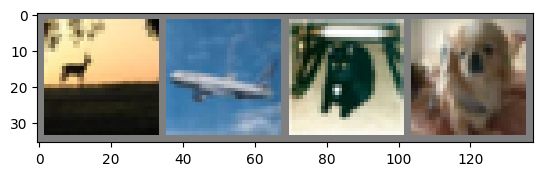

Epoch [1/5], Step [2000/12500], Loss: 2.2904
Epoch [1/5], Step [4000/12500], Loss: 2.3696
Epoch [1/5], Step [6000/12500], Loss: 1.9452
Epoch [1/5], Step [8000/12500], Loss: 2.0962
Epoch [1/5], Step [10000/12500], Loss: 1.9441
Epoch [1/5], Step [12000/12500], Loss: 2.1225
Epoch [2/5], Step [2000/12500], Loss: 1.9900
Epoch [2/5], Step [4000/12500], Loss: 2.1098
Epoch [2/5], Step [6000/12500], Loss: 1.9578
Epoch [2/5], Step [8000/12500], Loss: 2.0537
Epoch [2/5], Step [10000/12500], Loss: 1.8941
Epoch [2/5], Step [12000/12500], Loss: 1.9193
Epoch [3/5], Step [2000/12500], Loss: 1.7423
Epoch [3/5], Step [4000/12500], Loss: 1.9975
Epoch [3/5], Step [6000/12500], Loss: 1.8441
Epoch [3/5], Step [8000/12500], Loss: 1.7907
Epoch [3/5], Step [10000/12500], Loss: 1.7173
Epoch [3/5], Step [12000/12500], Loss: 2.3106
Epoch [4/5], Step [2000/12500], Loss: 1.4880
Epoch [4/5], Step [4000/12500], Loss: 2.0121
Epoch [4/5], Step [6000/12500], Loss: 1.5480
Epoch [4/5], Step [8000/12500], Loss: 1.8149
Epoc

In [ ]:
#Classification with improvedCNN_1
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

class ImprovedCNN_1(nn.Module):
    def __init__(self):
        super(ImprovedCNN_1, self).__init__()

        # Convolutional layers
        # 32*32*3 => 32*32*32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Batch normalization layers
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)

        # Dropout layers
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.batch_norm1(self.conv1(x)))
        #print(x.shape) #torch.Size([16, 32, 32, 32])
        x = self.pool(x)
        #print(x.shape) #torch.Size([16, 32, 16, 16])
        x = F.relu(self.batch_norm2(self.conv2(x)))
        #print(x.shape) #torch.Size([16, 64, 16, 16])
        x = self.pool(x)
        #print(x.shape) #torch.Size([16, 64, 8, 8])
        x = F.relu(self.batch_norm3(self.conv3(x)))
        #print(x.shape) #torch.Size([16, 128, 8, 8])
        x = self.pool(x)
        #print(x.shape) #torch.Size([16, 128, 4, 4])

      #flatenning
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.dropout(self.fc1(x)))
        x = self.fc2(x)


        return F.softmax(x, dim=1)

#training initialisation
learning_rate = 0.001
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ImprovedCNN_1()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')


Files already downloaded and verified
Files already downloaded and verified


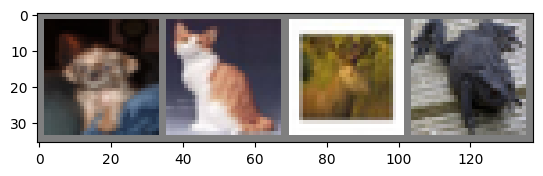

Epoch [1/5], Step [2000/12500], Loss: 2.3121
Epoch [1/5], Step [4000/12500], Loss: 2.2111
Epoch [1/5], Step [6000/12500], Loss: 2.0616
Epoch [1/5], Step [8000/12500], Loss: 2.1760
Epoch [1/5], Step [10000/12500], Loss: 2.1718
Epoch [1/5], Step [12000/12500], Loss: 2.2055
Epoch [2/5], Step [2000/12500], Loss: 2.2895
Epoch [2/5], Step [4000/12500], Loss: 1.9990
Epoch [2/5], Step [6000/12500], Loss: 2.1297
Epoch [2/5], Step [8000/12500], Loss: 1.8548
Epoch [2/5], Step [10000/12500], Loss: 1.9049
Epoch [2/5], Step [12000/12500], Loss: 1.6000
Epoch [3/5], Step [2000/12500], Loss: 1.9094
Epoch [3/5], Step [4000/12500], Loss: 2.0642
Epoch [3/5], Step [6000/12500], Loss: 1.6892
Epoch [3/5], Step [8000/12500], Loss: 1.8924
Epoch [3/5], Step [10000/12500], Loss: 1.7784
Epoch [3/5], Step [12000/12500], Loss: 1.7349
Epoch [4/5], Step [2000/12500], Loss: 1.9840
Epoch [4/5], Step [4000/12500], Loss: 2.2062
Epoch [4/5], Step [6000/12500], Loss: 1.6690
Epoch [4/5], Step [8000/12500], Loss: 1.8863
Epoc

In [ ]:
#Classification with ImprovedCNN_2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4
learning_rate = 0.001

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

class ImprovedCNN_2(nn.Module):
    def __init__(self):
        super(ImprovedCNN_2, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        # Batch normalization layers
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.batch_norm4 = nn.BatchNorm2d(64)
        self.batch_norm5 = nn.BatchNorm2d(128)
        self.batch_norm6 = nn.BatchNorm2d(128)

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)

        # Dropout layers
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
      #Block1
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = self.pool(x)
      #Block2
        x = F.relu(self.batch_norm3(self.conv3(x)))
        x = F.relu(self.batch_norm4(self.conv4(x)))
        x = self.pool(x)
      #Block3
        x = F.relu(self.batch_norm5(self.conv5(x)))
        x = F.relu(self.batch_norm6(self.conv6(x)))
        x = self.pool(x)
      #flatenning
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.dropout(self.fc1(x)))
      #classification
        x = self.fc2(x)

        return F.softmax(x, dim=1)

#training initialisation
learning_rate = 0.001
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ImprovedCNN_2()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')
